#  Intro to the Dataset and the Aim
<img src="loantap_logo.png" alt="LoanTap logo banner" style="width: 800px;"/>

**Problem Statement**: LoanTap, an online platform offering customized loan products, is facing challenges in efficiently assessing the creditworthiness of loan applicants. By predicting the likelihood of default, the company aims to minimize risks and improve the decision-making process for loan approvals.

**Objective**: The goal is to develop a machine learning model that can predict whether an applicant will default on a personal loan, based on their financial and credit history attributes. The model should help LoanTap make data-driven decisions, reducing the overall risk of default.

**Dataset Overview**: LoanTap has provided a dataset containing various financial and credit-related features for loan applicants. Below is a summary of the dataset:

| Column               | Description                                                        |
|----------------------|--------------------------------------------------------------------|
| loan_amnt            | The loan amount applied for by the borrower                        |
| term                 | Loan term in months (36 or 60)                                     |
| int_rate             | Interest rate on the loan                                          |
| installment          | Monthly payment owed if the loan originates                        |
| grade                | LoanTap assigned grade                                             |
| sub_grade            | LoanTap assigned subgrade                                          |
| emp_title            | Job title supplied by the borrower                                 |
| emp_length           | Employment length in years (0-10)                                  |
| home_ownership       | Home ownership status                                              |
| annual_inc           | Self-reported annual income                                        |
| verification_status  | Income verification status (verified/not verified)                 |
| issue_d              | Date the loan was funded                                           |
| loan_status          | Target variable (current loan status: default or not)              |
| purpose              | Purpose of the loan                                                |
| dti                  | Debt-to-income ratio                                               |
| earliest_cr_line     | Month the borrower’s earliest credit line was opened               |
| open_acc             | Number of open credit lines                                        |
| pub_rec              | Number of derogatory public records                                |
| revol_bal            | Total revolving credit balance                                     |
| revol_util           | Revolving line utilization rate                                    |
| total_acc            | Total number of credit lines                                       |
| initial_list_status  | The initial listing status of the loan. Possible values are – W, F |
| pub_rec              | Number of derogatory public records                                |
| application_type     | Individual or joint application                                    |
| mort_acc             | Number of mortgage accounts                                        |
| pub_rec_bankruptcies | Number of public record bankruptcies                               |
| address              | Address of the individual                                          |

**Aim**

1. To analyze which factors are critical in determining whether a borrower will default on a personal loan.
2. To develop a predictive model that estimates the likelihood of loan default based on borrower attributes.
3. Ensure interpretability of the model so LoanTap can understand the key drivers of defaults.

**Methods and Techniques used:** EDA, feature engineering, modeling using sklearn pipelines, hyperparameter tuning

**Measure of Performance and Minimum Threshold to reach the business objective** : Since both recall and precision are important, we will use maximize f1 score.

**Assumptions**
* The dataset is assumed to be representative of LoanTap’s entire customer base.
* The data remains stable over time, and thus, the model is assumed not to decay rapidly.
* External factors (e.g., economic downturns) are not considered, though they could influence loan repayment behavior.

## Library Setup

In [1]:
# Scientific libraries
import numpy as np
import pandas as pd


# Visual libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Helper libraries
from tqdm.notebook import tqdm, trange # Progress bar
import warnings 
#warnings.filterwarnings('ignore') # ignore all warkings

# To not cache lib import (.py modification won't refelect unless kernal restarts)
#%load_ext autoreload
#%autoreload 2

# Visual setup
%config InlineBackend.figure_format = 'retina' # sets the figure format to 'retina' for high-resolution displays.

# Pandas options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # display all interaction 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)

# Table styles
table_styles = {
    'cerulean_palette': [
        dict(selector="th", props=[("color", "#FFFFFF"), ("background", "#004D80")]),
        dict(selector="td", props=[("color", "#333333")]),
        dict(selector="table", props=[("font-family", 'Arial'), ("border-collapse", "collapse")]),
        dict(selector='tr:nth-child(even)', props=[('background', '#D3EEFF')]),
        dict(selector='tr:nth-child(odd)', props=[('background', '#FFFFFF')]),
        dict(selector="th", props=[("border", "1px solid #0070BA")]),
        dict(selector="td", props=[("border", "1px solid #0070BA")]),
        dict(selector="tr:hover", props=[("background", "#80D0FF")]),
        dict(selector="tr", props=[("transition", "background 0.5s ease")]),
        dict(selector="th:hover", props=[("font-size", "1.07rem")]),
        dict(selector="th", props=[("transition", "font-size 0.5s ease-in-out")]),
        dict(selector="td:hover", props=[('font-size', '1.07rem'),('font-weight', 'bold')]),
        dict(selector="td", props=[("transition", "font-size 0.5s ease-in-out")])
    ]
}


import sys
import os
# Get the path to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..')) # root dir of project

# Add the parent directory to the system path (can import from anywhere)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from loantap_credit_default_risk_model import config # custom config data for this project
    


# Seed value for numpy.random => makes notebooks stable across runs
np.random.seed(config.RANDOM_SEED)

## Data Ingestion

In [2]:
from loantap_credit_default_risk_model import data_handling as dh
    
df = dh.load_data_and_sanitize(config.FILE_NAME)

df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
display(df.head(10).style.set_table_styles(table_styles['cerulean_palette']).set_caption("DF"))
df.info()
df.describe()

/tmp/ipykernel_1194578/792396875.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.000000,36 months,11.440000,329.480000,B,B4,Marketing,10+ years,RENT,117000.000000,Not Verified,2015-01-01 00:00:00,Fully Paid,vacation,Vacation,26.240000,1990-06-01 00:00:00,16.000000,0.000000,36369.000000,41.800000,25.000000,w,INDIVIDUAL,0.000000,0.000000,"0174 Michelle Gateway Mendozaberg, OK 22690"
1,8000.000000,36 months,11.990000,265.680000,B,B5,Credit analyst,4 years,MORTGAGE,65000.000000,Not Verified,2015-01-01 00:00:00,Fully Paid,debt_consolidation,Debt consolidation,22.050000,2004-07-01 00:00:00,17.000000,0.000000,20131.000000,53.300000,27.000000,f,INDIVIDUAL,3.000000,0.000000,"1076 Carney Fort Apt. 347 Loganmouth, SD 05113"
2,15600.000000,36 months,10.490000,506.970000,B,B3,Statistician,< 1 year,RENT,43057.000000,Source Verified,2015-01-01 00:00:00,Fully Paid,credit_card,Credit card refinancing,12.790000,2007-08-01 00:00:00,13.000000,0.000000,11987.000000,92.200000,26.000000,f,INDIVIDUAL,0.000000,0.000000,"87025 Mark Dale Apt. 269 New Sabrina, WV 05113"
3,7200.000000,36 months,6.490000,220.650000,A,A2,Client Advocate,6 years,RENT,54000.000000,Not Verified,2014-11-01 00:00:00,Fully Paid,credit_card,Credit card refinancing,2.600000,2006-09-01 00:00:00,6.000000,0.000000,5472.000000,21.500000,13.000000,f,INDIVIDUAL,0.000000,0.000000,"823 Reid Ford Delacruzside, MA 00813"
4,24375.000000,60 months,17.270000,609.330000,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.000000,Verified,2013-04-01 00:00:00,Charged Off,credit_card,Credit Card Refinance,33.950000,1999-03-01 00:00:00,13.000000,0.000000,24584.000000,69.800000,43.000000,f,INDIVIDUAL,1.000000,0.000000,"679 Luna Roads Greggshire, VA 11650"
5,20000.000000,36 months,13.330000,677.070000,C,C3,HR Specialist,10+ years,MORTGAGE,86788.000000,Verified,2015-09-01 00:00:00,Fully Paid,debt_consolidation,Debt consolidation,16.310000,2005-01-01 00:00:00,8.000000,0.000000,25757.000000,100.600000,23.000000,f,INDIVIDUAL,4.000000,0.000000,"1726 Cooper Passage Suite 129 North Deniseberg, DE 30723"
6,18000.000000,36 months,5.320000,542.070000,A,A1,Software Development Engineer,2 years,MORTGAGE,125000.000000,Source Verified,2015-09-01 00:00:00,Fully Paid,home_improvement,Home improvement,1.360000,2005-08-01 00:00:00,8.000000,0.000000,4178.000000,4.900000,25.000000,f,INDIVIDUAL,3.000000,0.000000,"1008 Erika Vista Suite 748 East Stephanie, TX 22690"
7,13000.000000,36 months,11.140000,426.470000,B,B2,Office Depot,10+ years,RENT,46000.000000,Not Verified,2012-09-01 00:00:00,Fully Paid,credit_card,No More Credit Cards,26.870000,1994-09-01 00:00:00,11.000000,0.000000,13425.000000,64.500000,15.000000,f,INDIVIDUAL,0.000000,0.000000,USCGC Nunez FPO AE 30723
8,18900.000000,60 months,10.990000,410.840000,B,B3,Application Architect,10+ years,RENT,103000.000000,Verified,2014-10-01 00:00:00,Fully Paid,debt_consolidation,Debt consolidation,12.520000,1994-06-01 00:00:00,13.000000,0.000000,18637.000000,32.900000,40.000000,w,INDIVIDUAL,3.000000,0.000000,USCGC Tran FPO AP 22690
9,26300.000000,36 months,16.290000,928.400000,C,C5,Regado Biosciences,3 years,MORTGAGE,115000.000000,Verified,2012-04-01 00:00:00,Fully Paid,debt_consolidation,Debt Consolidation,23.690000,1997-12-01 00:00:00,13.000000,0.000000,22171.000000,82.400000,37.000000,f,INDIVIDUAL,1.000000,0.000000,"3390 Luis Rue Mauricestad, VA 00813"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  float64       
 1   term                  396030 non-null  object        
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  object        
 5   sub_grade             396030 non-null  object        
 6   emp_title             373103 non-null  object        
 7   emp_length            377729 non-null  object        
 8   home_ownership        396030 non-null  object        
 9   annual_inc            396030 non-null  float64       
 10  verification_status   396030 non-null  object        
 11  issue_d               396030 non-null  datetime64[ns]
 12  loan_status           396030 non-null  object        
 13 

,loan_amnt,int_rate,installment,annual_inc,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030,396030.000000,396030,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,2014-02-02 15:57:58.045602560,17.379514,1998-05-03 09:34:15.062495488,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
min,500.000000,5.320000,16.080000,0.000000e+00,2007-06-01 00:00:00,0.000000,1944-01-01 00:00:00,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,2013-05-01 00:00:00,11.280000,1994-10-01 00:00:00,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,2014-04-01 00:00:00,16.910000,1999-09-01 00:00:00,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,2015-03-01 00:00:00,22.980000,2003-04-01 00:00:00,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,2016-12-01 00:00:00,9999.000000,2013-10-01 00:00:00,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000
std,8357.441341,4.472157,250.727790,6.163762e+04,NaN,18.019092,NaN,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174


# EDA

In [3]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_notebook_iframe()

## Test data 
Separate the test data before visualisation to avoid data snooping bias

In [4]:
from sklearn.model_selection import train_test_split
X = df.drop('loan_status', axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify= y) # default it will shuffle data set before sampling

# Feature Engineering
* `int_rate`, `issue_d`, `installment` are found after loan is approved, thus they are removed from the dataset to avoid data leakage
* `emp_title` and `address`  has many categorical values thus to avoid curse of dimensionality, it is removed from the dataset (#TODO use NLP to extract feature from this)
* `earliest_cr_line` is not used because absolute data values are not useful and can affect the model, instead a relative date called `age_of_credit` is created #TODO

In [5]:
from loantap_credit_default_risk_model.config import *

## Feature Engineering Pipelines
* Below pipeline is made after repeated iteration of feature improvement, feature construction and finally feature selection
* All the pipelines where evaluated on using the confusion matrix and best as per business objective was chosen 

In [6]:
from loantap_credit_default_risk_model.FE_pipeline import target_pipeline,selected_FE_with_FS,all_nominal_cat,categorical_nominal_pipeline

## Feature Evaluation
* `ExtraTreesClassifier` is used for feature evaluation as it is least computationally expensive

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import time

from loantap_credit_default_risk_model.evaluation import feature_engg_evaluator, tune_model_threshold_adjustment # custom helper function

best_model = feature_engg_evaluator(X_train, y_train, X_test, y_test, selected_FE_with_FS,target_pipeline)


Parsing took 0.00 seconds
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training took 17.34 seconds
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     95507
           1       0.75      0.52      0.61     23302

    accuracy                           0.87    118809
   macro avg       0.82      0.74      0.77    118809
weighted avg       0.86      0.87      0.86    118809

Overall took 19.10 seconds


In [8]:
from loantap_credit_default_risk_model.FE_pipeline import selected_FE_with_FS
selected_FE_with_FS.set_output(transform='pandas')
selected_FE_with_FS.fit(X_train, y_train)

config.POST_FE_FEATURES=selected_FE_with_FS.transform(X_test).columns
feature_importance_df = pd.DataFrame({
    'feature': config.POST_FE_FEATURES,
    'importance': best_model['base_model'].feature_importances_
}).sort_values('importance', ascending=False, key=abs)

feature_importance_df.style.set_table_styles(table_styles['cerulean_palette']).set_caption("LR Feature Importance")

Pipeline(steps=[('feature_engineering_pipeline',
                 FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                 Pipeline(steps=[('all_numerical',
                                                                  FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                  Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                   FunctionTransformer(func=<function <lambda> at 0x77f4aa120b80>)),
                                                                                                                  ('FE_improvement_impute',
                                                                                                                   SimpleIm...
                                                                                                 ('FE_construction_state',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x77f4a8481440>))])),
                                                                 ('FE_improvement_impute',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('FE_construction_OHE',
                                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                min_frequency=0.01,
                                                                                sparse_output=False))]))])),
                ('feature_selection_pipeline',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x77f4a97c7e20>))])

Pipeline(steps=[('feature_engineering_pipeline',
                 FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                 Pipeline(steps=[('all_numerical',
                                                                  FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                  Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                   FunctionTransformer(func=<function <lambda> at 0x77f4aa120b80>)),
                                                                                                                  ('FE_improvement_impute',
                                                                                                                   SimpleIm...
                                                                                                 ('FE_construction_state',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x77f4a8481440>))])),
                                                                 ('FE_improvement_impute',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('FE_construction_OHE',
                                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                min_frequency=0.01,
                                                                                sparse_output=False))]))])),
                ('feature_selection_pipeline',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x77f4a97c7e20>))])

,feature,importance
26,zipcode_11650,0.122248
29,zipcode_93700,0.120942
28,zipcode_86630,0.118127
9,sub_grade,0.104348
5,revol_util,0.068403
6,age_of_credit,0.062732
4,loan_amnt,0.062686
2,open_acc,0.057445
10,verification_status,0.035197
8,grade,0.033196


# Model Selection and Training

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

LR_with_FE = Pipeline([
    ('feature_engineering_pipeline', selected_FE_with_FS),
    ('base_model', LogisticRegression())
])


LR_with_FE_CV = GridSearchCV(
    estimator=LR_with_FE,
    param_grid={
        'base_model__C': [0.01],
        'base_model__solver': ['saga'],
        'base_model__penalty': ['elasticnet'],
        'base_model__class_weight': ['balanced'],
        'base_model__l1_ratio': [0.6],
        'base_model__max_iter': [1000],
        'base_model__warm_start': [True]
    },
    scoring='f1',
    cv=3,
    n_jobs=config.N_JOBS,
    verbose=True
)
y_train_transformed = target_pipeline.transform(y_train)
y_test_transformed = target_pipeline.transform(y_test)

LR_with_FE_CV.fit(X_train, y_train_transformed)
LR_best_model = LR_with_FE_CV.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                        Pipeline(steps=[('feature_engineering_pipeline',
                                                         FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                                                         Pipeline(steps=[('all_numerical',
                                                                                                          FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                                                          Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                                                           FunctionTransformer...
                                                                     score_func=<function chi2 at 0x77f4a97c7e20>))])),
                                       ('base_model', LogisticRegression())]),
             n_jobs=8,
             param_grid={'base_model__C': [0.01],
                         'base_model__class_weight': ['balanced'],
                         'base_model__l1_ratio': [0.6],
                         'base_model__max_iter': [1000],
                         'base_model__penalty': ['elasticnet'],
                         'base_model__solver': ['saga'],
                         'base_model__warm_start': [True]},
             scoring='f1', verbose=True)

In [10]:
# Finding the performance of best model
y_pred=LR_best_model.predict(X_test)
print(classification_report(y_test_transformed, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     95507
           1       0.51      0.79      0.62     23302

    accuracy                           0.81    118809
   macro avg       0.73      0.80      0.75    118809
weighted avg       0.86      0.81      0.82    118809



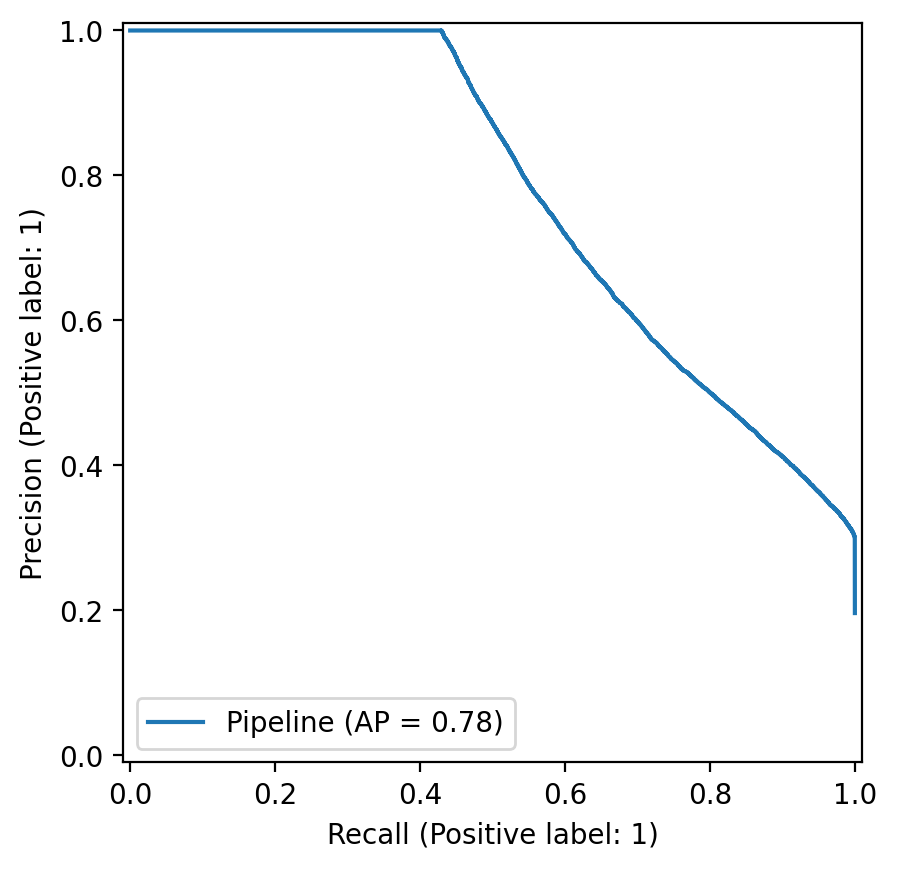

In [11]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(LR_best_model, X_test, target_pipeline.transform(y_test))

### Threshold Adjustment for Logistic Regression

Classification report: Training set
              precision    recall  f1-score   support

           0       0.91      0.93      0.92    222850
           1       0.69      0.62      0.65     54371

    accuracy                           0.87    277221
   macro avg       0.80      0.78      0.79    277221
weighted avg       0.87      0.87      0.87    277221

Classification report: Testing set
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     95507
           1       0.69      0.62      0.65     23302

    accuracy                           0.87    118809
   macro avg       0.80      0.78      0.79    118809
weighted avg       0.87      0.87      0.87    118809

Best threshold = 0.65 with f1 score = 0.65


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                                      Pipeline(steps=[('feature_engineering_pipeline',
                                                                       FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                                                                       Pipeline(steps=[('all_numerical',
                                                                                                                        FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                                                                        Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                                                                         Funct...
                                                                                                                        OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                                                      min_frequency=0.01,
                                                                                                                                      sparse_output=False))]))])),
                                                                      ('feature_selection_pipeline',
                                                                       SelectKBest(k=30,
                                                                                   score_func=<function chi2 at 0x77f4a97c7e20>))])),
                                                     ('base_model',
                                                      LogisticRegression(C=0.01,
                                                                         class_weight='balanced',
                                                                         l1_ratio=0.6,
                                                                         max_iter=1000,
                                                                         penalty='elasticnet',
                                                                         solver='saga',
                                                                         warm_start=True))]),
                           n_jobs=8, scoring='f1', store_cv_results=True)

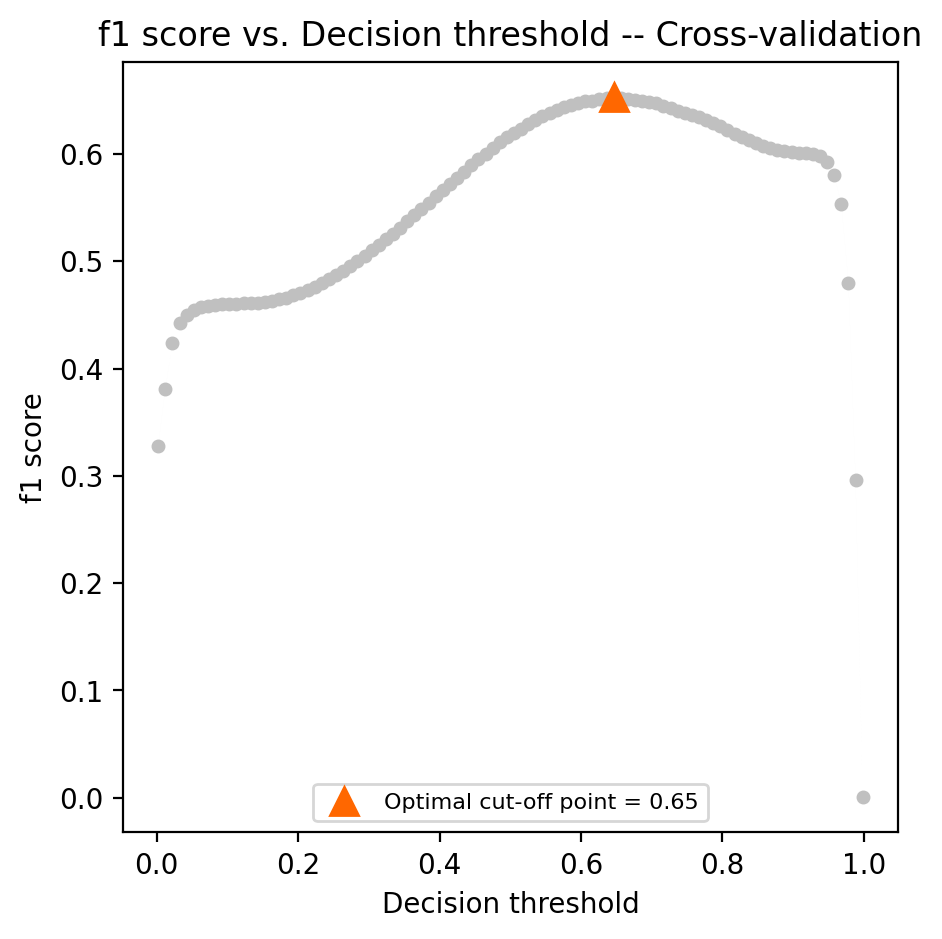

In [12]:
# Post tuning of selected best model (threshold adjustment as per business requirements)
tune_model_threshold_adjustment(LR_best_model, X_train, y_train, X_test, y_test,scoring='f1',target_pipeline=target_pipeline)

In [13]:
# Feature Importance
feature_importance_df = pd.DataFrame({
    'feature': config.POST_FE_FEATURES,
    'importance': LR_best_model['base_model'].coef_[0]
}).sort_values('importance', ascending=False, key=abs)

feature_importance_df.style.set_table_styles(table_styles['cerulean_palette']).set_caption("LR Feature Importance")

,feature,importance
26,zipcode_11650,4.418252
24,zipcode_00813,-4.407980
25,zipcode_05113,-4.406986
29,zipcode_93700,4.403967
27,zipcode_29597,-4.403342
28,zipcode_86630,4.376041
0,annual_inc,-0.918721
1,dti,0.665454
19,purpose_small_business,0.373103
7,term,0.360285


## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

RF_with_FE = Pipeline([
    ('feature_engineering_pipeline', selected_FE_with_FS),
    ('base_model', RandomForestClassifier())
])


RF_with_FE_CV = GridSearchCV(
    estimator=RF_with_FE,
    param_grid={
        'base_model__n_estimators': [120],
        'base_model__max_depth': [5],
        'base_model__min_samples_split': [9],
        'base_model__min_samples_leaf': [2],
        'base_model__criterion': ['entropy'],
        'base_model__warm_start': [True],
    },
    scoring='f1',
    cv=3,
    n_jobs=config.N_JOBS,
    verbose=True
)

RF_with_FE_CV.fit(X_train, y_train_transformed)
RF_best_model = RF_with_FE_CV.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                        Pipeline(steps=[('feature_engineering_pipeline',
                                                         FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                                                         Pipeline(steps=[('all_numerical',
                                                                                                          FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                                                          Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                                                           FunctionTransformer...
                                                         SelectKBest(k=30,
                                                                     score_func=<function chi2 at 0x77f4a97c7e20>))])),
                                       ('base_model',
                                        RandomForestClassifier())]),
             n_jobs=8,
             param_grid={'base_model__criterion': ['entropy'],
                         'base_model__max_depth': [5],
                         'base_model__min_samples_leaf': [2],
                         'base_model__min_samples_split': [9],
                         'base_model__n_estimators': [120],
                         'base_model__warm_start': [True]},
             scoring='f1', verbose=True)

Classification report: Training set
              precision    recall  f1-score   support

           0       0.90      0.95      0.92    222850
           1       0.73      0.58      0.64     54371

    accuracy                           0.87    277221
   macro avg       0.81      0.76      0.78    277221
weighted avg       0.87      0.87      0.87    277221

Classification report: Testing set
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     95507
           1       0.73      0.58      0.65     23302

    accuracy                           0.88    118809
   macro avg       0.82      0.77      0.79    118809
weighted avg       0.87      0.88      0.87    118809

Best threshold = 0.25 with f1 score = 0.65


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                                      Pipeline(steps=[('feature_engineering_pipeline',
                                                                       FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                                                                       Pipeline(steps=[('all_numerical',
                                                                                                                        FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                                                                        Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                                                                         Funct...
                                                                                                                        OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                                                      min_frequency=0.01,
                                                                                                                                      sparse_output=False))]))])),
                                                                      ('feature_selection_pipeline',
                                                                       SelectKBest(k=30,
                                                                                   score_func=<function chi2 at 0x77f4a97c7e20>))])),
                                                     ('base_model',
                                                      RandomForestClassifier(criterion='entropy',
                                                                             max_depth=5,
                                                                             min_samples_leaf=2,
                                                                             min_samples_split=9,
                                                                             n_estimators=120,
                                                                             warm_start=True))]),
                           n_jobs=8, scoring='f1', store_cv_results=True)

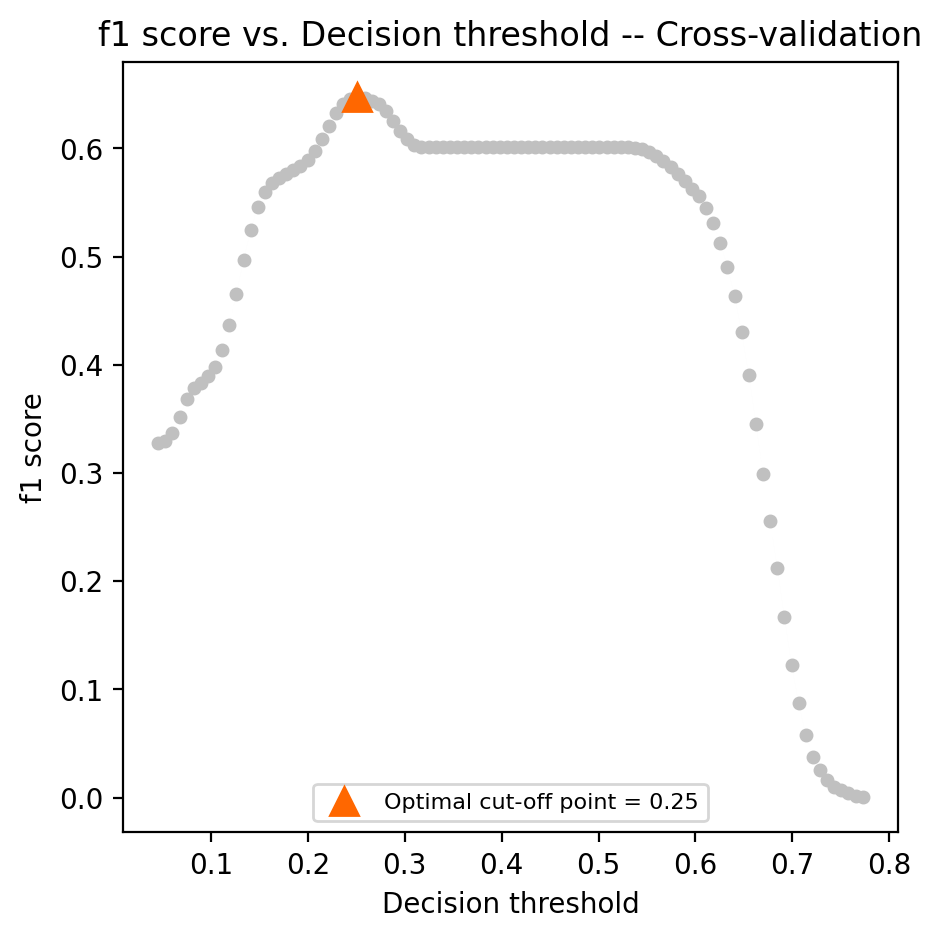

In [15]:
# Post tuning of selected best model (threshold adjustment as per business requirements)
tune_model_threshold_adjustment(RF_best_model, X_train, y_train, X_test, y_test,scoring='f1',target_pipeline=target_pipeline)

In [16]:
# Feature Importance
feature_importance_df = pd.DataFrame({
    'feature': config.POST_FE_FEATURES,
    'importance': RF_best_model['base_model'].feature_importances_
}).sort_values('importance', ascending=False, key=abs)

feature_importance_df.style.set_table_styles(table_styles['cerulean_palette']).set_caption("LR Feature Importance")

,feature,importance
26,zipcode_11650,0.206213
29,zipcode_93700,0.196046
28,zipcode_86630,0.173207
25,zipcode_05113,0.100700
27,zipcode_29597,0.093396
24,zipcode_00813,0.086586
9,sub_grade,0.052747
8,grade,0.046681
7,term,0.020258
1,dti,0.008938


## Gradient Boosting

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

GBDT_with_FE = Pipeline([
    ('feature_engineering_pipeline', selected_FE_with_FS),
    ('base_model', GradientBoostingClassifier())
])


GBDT_with_FE_CV = GridSearchCV(
    estimator=GBDT_with_FE,
    param_grid={
        'base_model__n_estimators': [100],
        'base_model__learning_rate': [0.3],
        'base_model__subsample': [0.8],
        'base_model__max_depth': [5],
        'base_model__min_samples_split': [10],
        'base_model__min_samples_leaf': [4],
        'base_model__warm_start': [True],
    },
    scoring='f1',
    cv=3,
    n_jobs=config.N_JOBS,
    verbose=True
)

GBDT_with_FE_CV.fit(X_train, y_train_transformed)
GBDT_best_model = GBDT_with_FE_CV.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                        Pipeline(steps=[('feature_engineering_pipeline',
                                                         FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                                                         Pipeline(steps=[('all_numerical',
                                                                                                          FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                                                          Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                                                           FunctionTransformer...
                                                                     score_func=<function chi2 at 0x77f4a97c7e20>))])),
                                       ('base_model',
                                        GradientBoostingClassifier())]),
             n_jobs=8,
             param_grid={'base_model__learning_rate': [0.3],
                         'base_model__max_depth': [5],
                         'base_model__min_samples_leaf': [4],
                         'base_model__min_samples_split': [10],
                         'base_model__n_estimators': [100],
                         'base_model__subsample': [0.8],
                         'base_model__warm_start': [True]},
             scoring='f1', verbose=True)

Classification report: Training set
              precision    recall  f1-score   support

           0       0.91      0.94      0.92    222850
           1       0.71      0.64      0.67     54371

    accuracy                           0.88    277221
   macro avg       0.81      0.79      0.80    277221
weighted avg       0.87      0.88      0.88    277221

Classification report: Testing set
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     95507
           1       0.69      0.62      0.66     23302

    accuracy                           0.87    118809
   macro avg       0.80      0.78      0.79    118809
weighted avg       0.87      0.87      0.87    118809

Best threshold = 0.32 with f1 score = 0.65


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                                      Pipeline(steps=[('feature_engineering_pipeline',
                                                                       FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                                                                       Pipeline(steps=[('all_numerical',
                                                                                                                        FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                                                                        Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                                                                         Funct...
                                                                                                                        OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                                                      min_frequency=0.01,
                                                                                                                                      sparse_output=False))]))])),
                                                                      ('feature_selection_pipeline',
                                                                       SelectKBest(k=30,
                                                                                   score_func=<function chi2 at 0x77f4a97c7e20>))])),
                                                     ('base_model',
                                                      GradientBoostingClassifier(learning_rate=0.3,
                                                                                 max_depth=5,
                                                                                 min_samples_leaf=4,
                                                                                 min_samples_split=10,
                                                                                 subsample=0.8,
                                                                                 warm_start=True))]),
                           n_jobs=8, scoring='f1', store_cv_results=True)

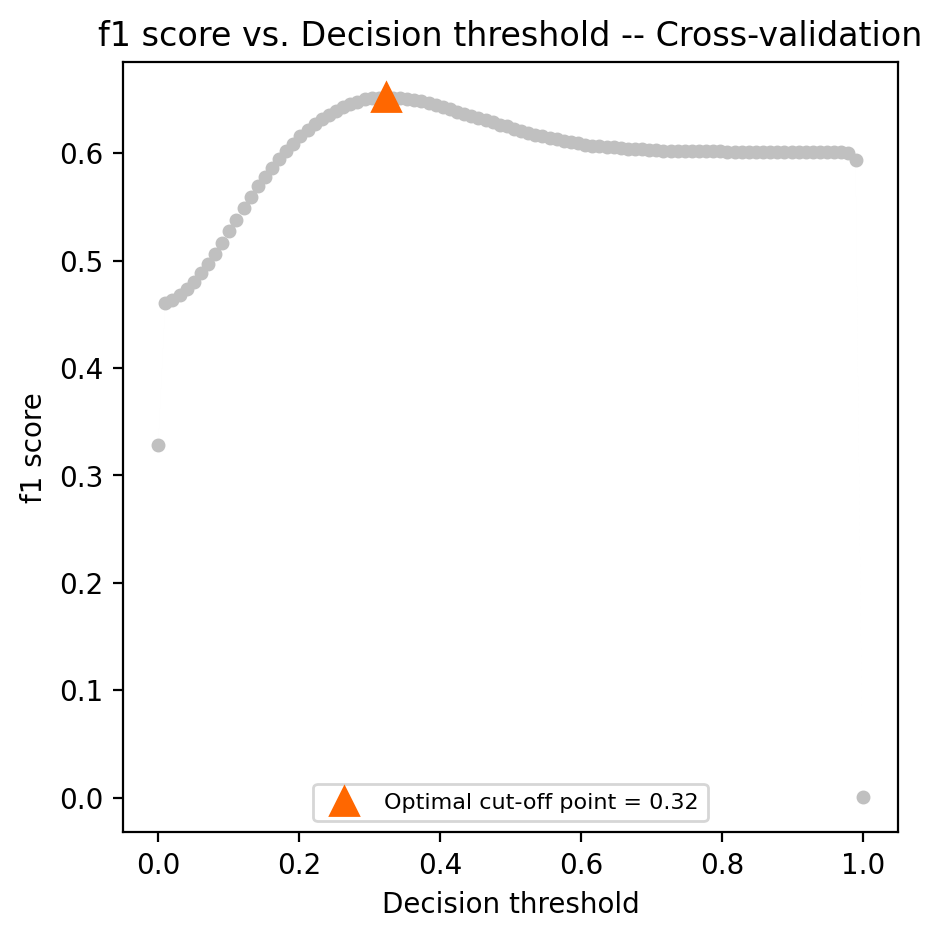

In [18]:
# Post tuning of selected best model (threshold adjustment as per business requirements)
tune_model_threshold_adjustment(GBDT_best_model, X_train, y_train, X_test, y_test,scoring='f1',target_pipeline=target_pipeline)

In [19]:
# Feature Importance DF
feature_importance_df = pd.DataFrame({
    'feature': config.POST_FE_FEATURES,
    'importance': GBDT_best_model['base_model'].feature_importances_
}).sort_values('importance', ascending=False, key=abs)

feature_importance_df.style.set_table_styles(table_styles['cerulean_palette']).set_caption("LR Feature Importance")

,feature,importance
28,zipcode_86630,0.247702
29,zipcode_93700,0.237871
26,zipcode_11650,0.227359
9,sub_grade,0.079794
25,zipcode_05113,0.061856
24,zipcode_00813,0.052671
27,zipcode_29597,0.046724
7,term,0.009176
1,dti,0.009169
11,home_ownership_mortgage,0.003241


## XGBoost

In [20]:
from xgboost import XGBClassifier

XGB_with_FE = Pipeline([
    ('feature_engineering_pipeline', selected_FE_with_FS),
    ('base_model', XGBClassifier())
])


XGB_with_FE_CV = GridSearchCV(
    estimator=XGB_with_FE,
    param_grid={
        'base_model__max_depth': [5], 
        'base_model__learning_rate': [0.15],
        'base_model__n_estimators': [300], 
        'base_model__gamma': [0], 
        'base_model__subsample': [0.95], 
        'base_model__colsample_bytree': [0.95], 
        'base_model__lambda': [0.1],
        'base_model__tree_method': ["hist"],
        'base_model__eval_metric': ["aucpr"]
    },
    scoring='f1',
    cv=3,
    n_jobs=8,
    verbose=True
)

XGB_with_FE_CV.fit(X_train, y_train_transformed)
XGB_best_model = XGB_with_FE_CV.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                        Pipeline(steps=[('feature_engineering_pipeline',
                                                         FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                                                         Pipeline(steps=[('all_numerical',
                                                                                                          FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                                                          Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                                                           FunctionTransformer...
                                                      random_state=None, ...))]),
             n_jobs=8,
             param_grid={'base_model__colsample_bytree': [0.95],
                         'base_model__eval_metric': ['aucpr'],
                         'base_model__gamma': [0], 'base_model__lambda': [0.1],
                         'base_model__learning_rate': [0.15],
                         'base_model__max_depth': [5],
                         'base_model__n_estimators': [300],
                         'base_model__subsample': [0.95],
                         'base_model__tree_method': ['hist']},
             scoring='f1', verbose=True)

Classification report: Training set
              precision    recall  f1-score   support

           0       0.91      0.94      0.92    222850
           1       0.71      0.64      0.67     54371

    accuracy                           0.88    277221
   macro avg       0.81      0.79      0.80    277221
weighted avg       0.87      0.88      0.88    277221

Classification report: Testing set
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     95507
           1       0.69      0.62      0.66     23302

    accuracy                           0.87    118809
   macro avg       0.80      0.78      0.79    118809
weighted avg       0.87      0.87      0.87    118809

Best threshold = 0.32 with f1 score = 0.65


TunedThresholdClassifierCV(cv=3,
                           estimator=Pipeline(steps=[('feature_engineering_pipeline',
                                                      Pipeline(steps=[('feature_engineering_pipeline',
                                                                       FeatureUnion(transformer_list=[('numerical_combined_pipeline',
                                                                                                       Pipeline(steps=[('all_numerical',
                                                                                                                        FeatureUnion(transformer_list=[('numerical_skewed_pipeline',
                                                                                                                                                        Pipeline(steps=[('select_numerical_skewed_features',
                                                                                                                                                                         Funct...
                                                                    interaction_constraints=None,
                                                                    lambda=0.1,
                                                                    learning_rate=0.15,
                                                                    max_bin=None,
                                                                    max_cat_threshold=None,
                                                                    max_cat_to_onehot=None,
                                                                    max_delta_step=None,
                                                                    max_depth=5,
                                                                    max_leaves=None,
                                                                    min_child_weight=None,
                                                                    missing=nan,
                                                                    monotone_constraints=None,
                                                                    multi_strategy=None,
                                                                    n_estimators=300,
                                                                    n_jobs=None,
                                                                    num_parallel_tree=None, ...))]),
                           n_jobs=8, scoring='f1', store_cv_results=True)

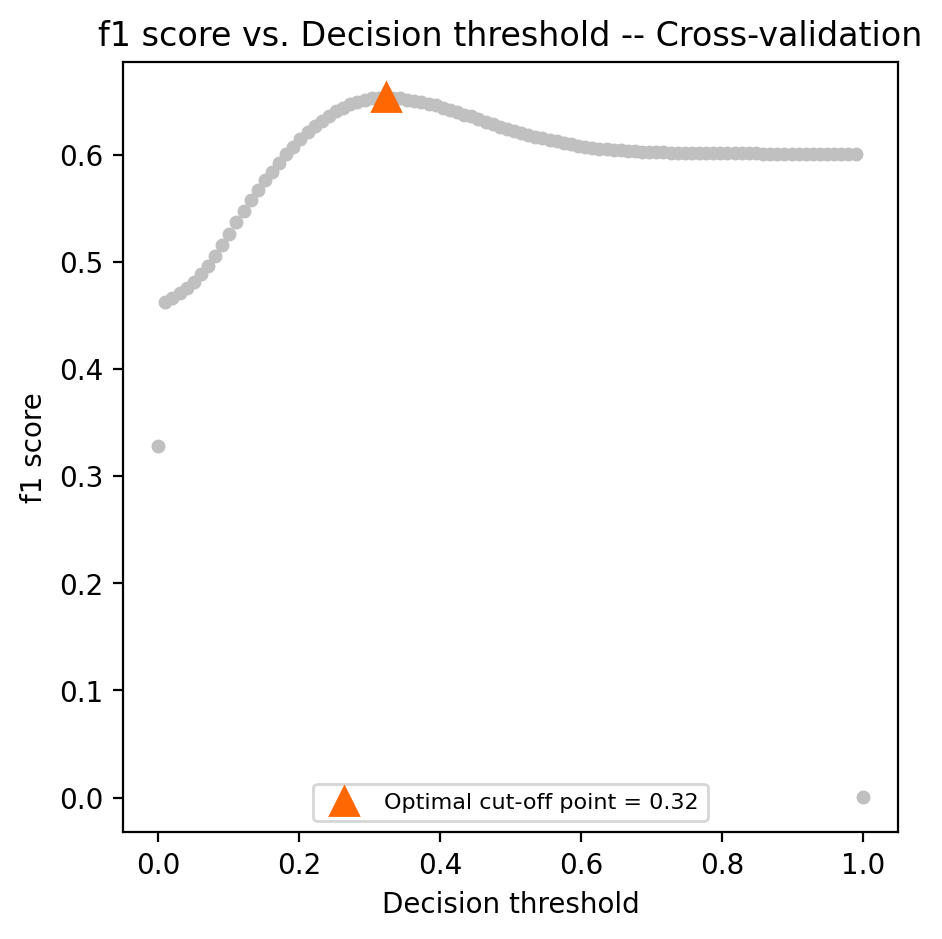

In [21]:
# Post tuning of selected best model (threshold adjustment as per business requirements)
tune_model_threshold_adjustment(XGB_best_model, X_train, y_train, X_test, y_test,scoring='f1',target_pipeline=target_pipeline)

In [22]:
# Feature Importance DF
feature_importance_df = pd.DataFrame({
    'feature': config.POST_FE_FEATURES,
    'importance': XGB_best_model['base_model'].feature_importances_
}).sort_values('importance', ascending=False, key=abs)

feature_importance_df.style.set_table_styles(table_styles['cerulean_palette']).set_caption("LR Feature Importance")

,feature,importance
28,zipcode_86630,0.234764
29,zipcode_93700,0.222357
26,zipcode_11650,0.203205
24,zipcode_00813,0.110202
25,zipcode_05113,0.103631
27,zipcode_29597,0.095307
8,grade,0.005121
9,sub_grade,0.004307
7,term,0.003948
1,dti,0.002548


# Conclusion
* Best model is XGBoost with f1 score of 0.66 and least test and training time.
* Most important feature is `zipcode` with from address followed by `grade` and `term`